# Treating experimental data

## A prelab assignment for analytical chemistry

<b>Author:</b> Ayla S. Coder <a href="mailto:aylcoder@gmail.com">✉️</a> 
<b>Editor:</b> Audun Skau Hansen <a href="mailto:a.s.hansen@kjemi.uio.no">✉️</a> 

The Hylleraas Centre for Quantum Molecular Sciences and
The Centre for Computing in Science Education,
2022

--- 
### Things you might need to know before tackling this notebook
Before starting this part of the prelab for analytical chemistry II, the following notebooks should be completed: 

<ul>
  <li><a href="https://openworldlearning.github.io/docs/software/gpr/polynomial_regression.html">Notebook on polynomial regression </a></li>
  <li><a href="https://openworldlearning.github.io/docs/software/gpr/Covariance.html">Notebook on covariance</a></li>
    
  <li><a href="https://openworldlearning.github.io/docs/software/gpr/Kernels.html">Notebook on kernels</a></li>
  
  <li><a href="https://openworldlearning.github.io/docs/software/gpr/GPR_intro.html">Notebook on guassian process regression</a></li>
    <li><a href="https://openworldlearning.github.io/docs/software/gpr/quick_gpr_tutorial.html">Notebook on how to implement the guassian process regression module</a></li>
       <li><a href="https://openworldlearning.github.io/docs/software/gpr/quick_gpr_tutorial.html">Notebook on factorial design and boxbehnken DOE</a></li>
    
</ul>

The goal of this notebook is to introduce you to Gaussian Process Regression in the context of a real life example of an analytical lab. We'll use response measurements, based on a Box-Behnken experimental setup for determining the optimal settings for (insert name of machine, explain better here). Let's begin with a preliminary discussion just to gather our thoughts:

```{admonition} Preliminary discussion
Based on what you know of Gaussian Process Regression and (refer to experimental setup):
- How do GPR differ from conventional methods like polynomial regression?    
- Do you expect to encounter an optimal response? Explain your answer.
- What are the experimental constraints for this setup? 
```

In [1]:
"""
Answer: 

"""

'\nAnswer: \n\n'

# Installation

We'll use the ```btjenesten``` module for this session. You can install it using:

In [2]:
!pip install btjenesten

/bin/bash: pip: command not found


Then you import the following modules:

In [3]:
import btjenesten as bt
import numpy as np
import matplotlib.pyplot as plt
import bubblebox as bb

%matplotlib notebook

# Data preparation

When dealing with large datasets it is convenient to work on sets of data directly, rather than the individual data points. For this reason, we'll make extensive use of the ```numpy``` array data type and it's associated methods. For more details on array handling, see the <a href="https://numpy.org/doc/stable/reference/generated/numpy.array.html">official Numpy documentation</a>.

Data from the Box-Behnken analysis is loaded below. Pay attention to the shape:

In [4]:
"""
All the data
"""
MgSO4 = np.array([30,   60,   90,   60,   30,   90,   30,   90,   60,   30,   90,   60,   60,   60,   60])
ACN   = np.array([0.75, 1.00, 1.00, 1.25, 0.75, 0.75, 1.25, 1.25, 0.75, 1.00, 1.00, 1.25, 1.00, 1.00, 1.00])
HCL   = np.array([6,    6,    6,    6,    12,   12,   12,   12,   18,   18,   18,   18,   12,   12,   12])
all_x = np.vstack([MgSO4, ACN, HCL]).T # The T transposes the stacked data into the correct shape.
# Try running this cell without the T to see what that means.

all_y = np.array([65626517, 48406988, 42143802, 26975625, 70941284, 66452677, \
26688204, 18157839, 73184566, 54919876, 9915204, 13288195, 17918550, 13380019, 19043787])


# The arrays containing all the data is printed below
print(all_x)
print("The shape of the all_x array is:", all_x.shape)
print("---")
print(all_y)
print ("The shape of the all_y array is: ", all_y.shape)




[[30.    0.75  6.  ]
 [60.    1.    6.  ]
 [90.    1.    6.  ]
 [60.    1.25  6.  ]
 [30.    0.75 12.  ]
 [90.    0.75 12.  ]
 [30.    1.25 12.  ]
 [90.    1.25 12.  ]
 [60.    0.75 18.  ]
 [30.    1.   18.  ]
 [90.    1.   18.  ]
 [60.    1.25 18.  ]
 [60.    1.   12.  ]
 [60.    1.   12.  ]
 [60.    1.   12.  ]]
The shape of the all_x array is: (15, 3)
---
[65626517 48406988 42143802 26975625 70941284 66452677 26688204 18157839
 73184566 54919876  9915204 13288195 17918550 13380019 19043787]
The shape of the all_y array is:  (15,)


It may also be instructive to visualize how the data distributes in the measurement domain:


In [5]:
bt.analysis.show_3d_sample_box(all_x).view() # Show the measurements in a threedimensional box

MDView(box=[4, 4, 4], colors=[[0.13901384296673214, 0.9885796432713619, 0.6107035989165626], [0.13901384296673…

As can be seen in the all_x array above, the last three measurements were performed on the exact same x-values. This is problematic for the ```btjenesten.gpr``` module, as the regressor cannot handle duplicates. 

In order to remove the redundancy, use the ```btjenesten.analysis.remove_redundancy``` function:

In [6]:
# remove redundance
all_x_, all_y_ = bt.analysis.remove_redundancy(all_x, all_y) # note that these all_x_ and all_y_ arrays are different than the first ones. 

print("The length of the x-array before removing the duplicates: ", len(all_x))
print("The length of the x-array after removing the duplicates : ", len(all_x_))



The length of the x-array before removing the duplicates:  15
The length of the x-array after removing the duplicates :  13


Note that this function computes the average of the responses from the duplicate measurements. This ensures that all responses are taken equally into account. 

```{admonition} Discussion 2
What kind of statistical analysis can be performed in order to remove apparently erroneous measurements such as outliers?
```

# Setting up the regressor

Next, we'll set up the Gaussian Process regressor by initializing it with the measured data. For more detailed information on how to do this, check out <a href="https://openworldlearning.github.io/docs/software/gpr/AI_in_the_lab.html">this tutorial</a>.

We will, however, **not** start out giving the full data set for the regressor. In order to choose the regressor parameter in a reasonable range, we'll instead give it a few (5) dispersed measurements, and chose our regressor parameters in such a way that the regressor gives reasonable predictions in the remaining points. 

A function ```btjenesten.analysis.choose_n_most_distant``` can be used to quickly pick these measurements, or you could pick them manually if you have reason to do so.



In [35]:
n = bt.analysis.choose_n_most_distant(all_x_, 6) #chose 5 training data points positioned far apart

# Here's an n that you can easily modify yourself: 
# n = np.array([index, index, index, index, index]) # Remember to not choose more than 13 indices. 

print("The indices of the picked out training data = ", n)

The indices of the picked out training data =  [ 6  7  2  9 10  0]


The ```btjenesten.gpr.regressor``` class has one parameter per dimension. These parameters determines the decay of the correlation in each dimension. Simply put, the higher the parameter for a given dinemsion, the more rapid a function is assumed to change in that dimension. A parameter set to zero signifies perfect correlation in that direction, meaning that changing the variable associated with that dimension does not make any impact on the value.

Picking the right parameters is complicated, so let's just try out a set and discuss the results:

<IPython.core.display.Javascript object>


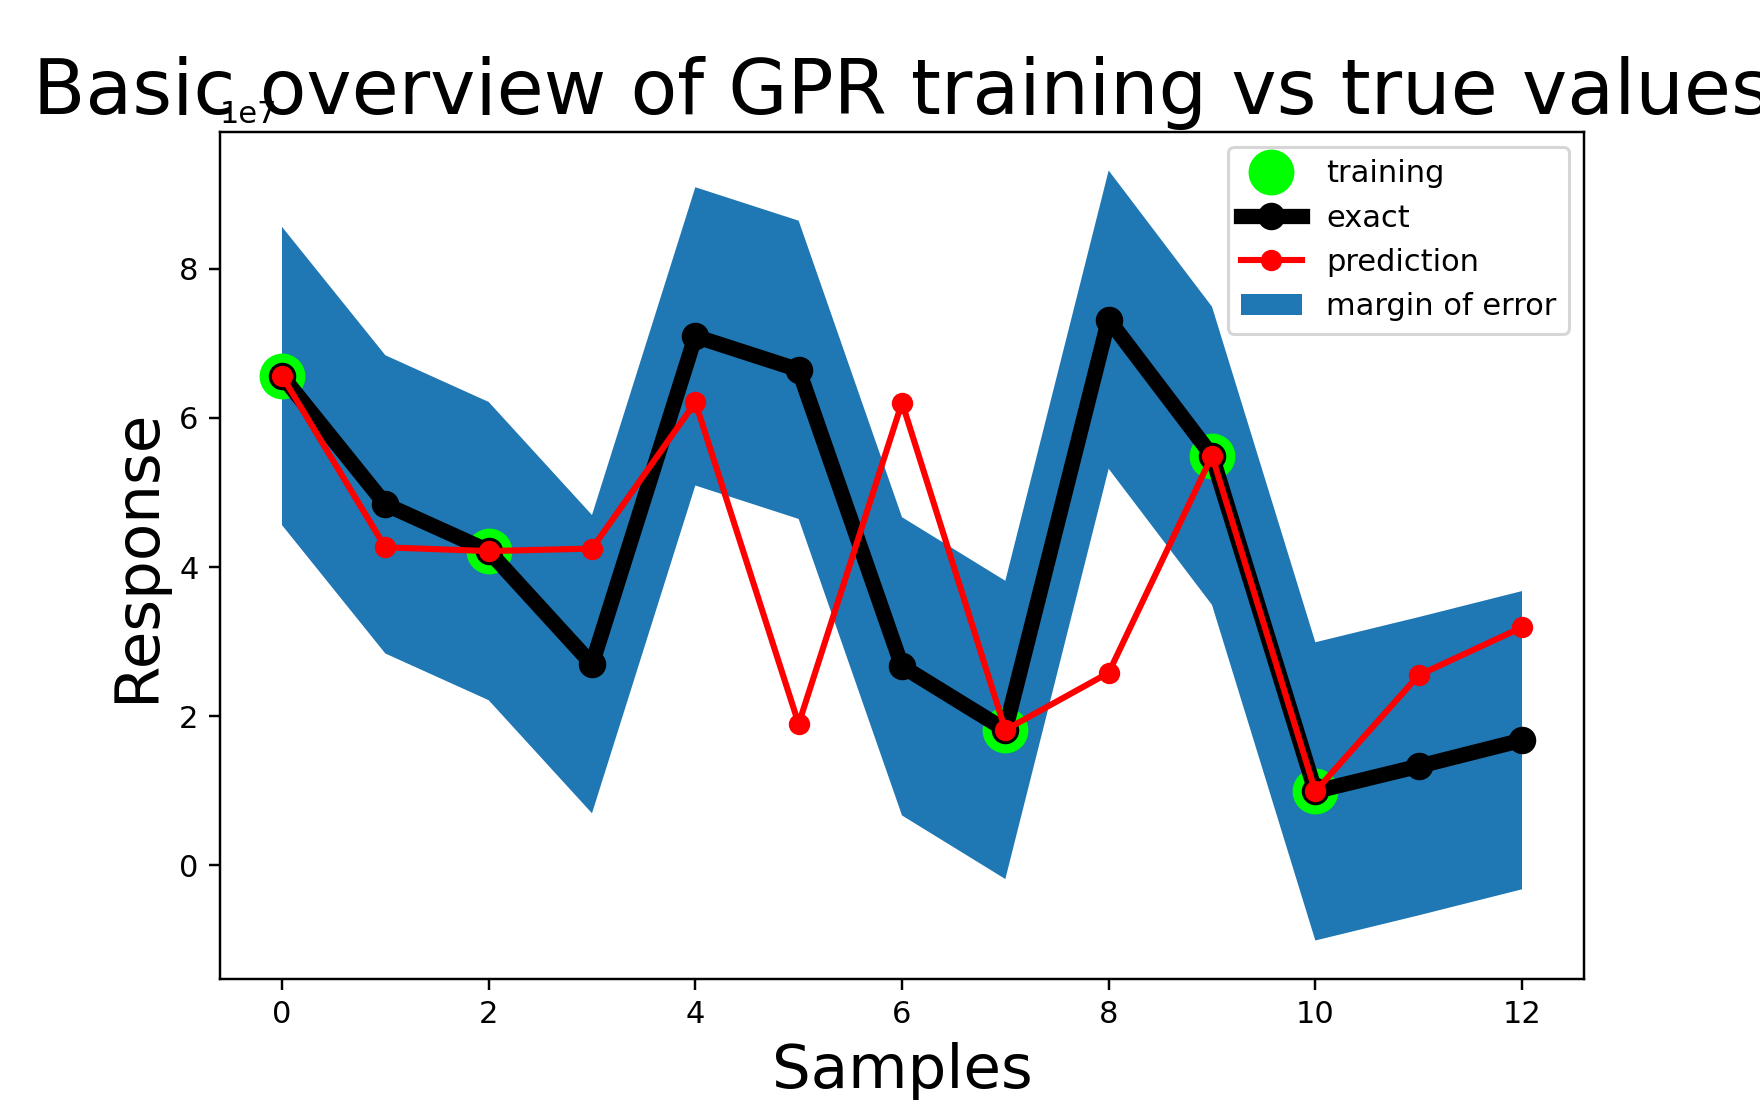

In [57]:
regressor = bt.gpr.Regressor(all_x_[n], all_y_[n])

regressor.params = np.array([.001, .001, .001])

bt.analysis.regressor_summary(all_x_, all_y_, regressor, n, error_margin = 2e7)


```{admonition} Discussion 3
- What does the figure above show? Explain it to eachother.
- Is the order of the samples of any real significance (ie, does rearranging them change the information conveyed in the graph)?
- Does it reveal any information on the optimum of the function with regards to the measured points?
- How do you expect it to change if you vary the parameters? (Feel free to try it out).
```

Ideally, we would like the parameters to be chosen as to minimize the difference between the predicted values in samples excluded from the training data. You can play a bit around to get a feel for it:

<IPython.core.display.Javascript object>


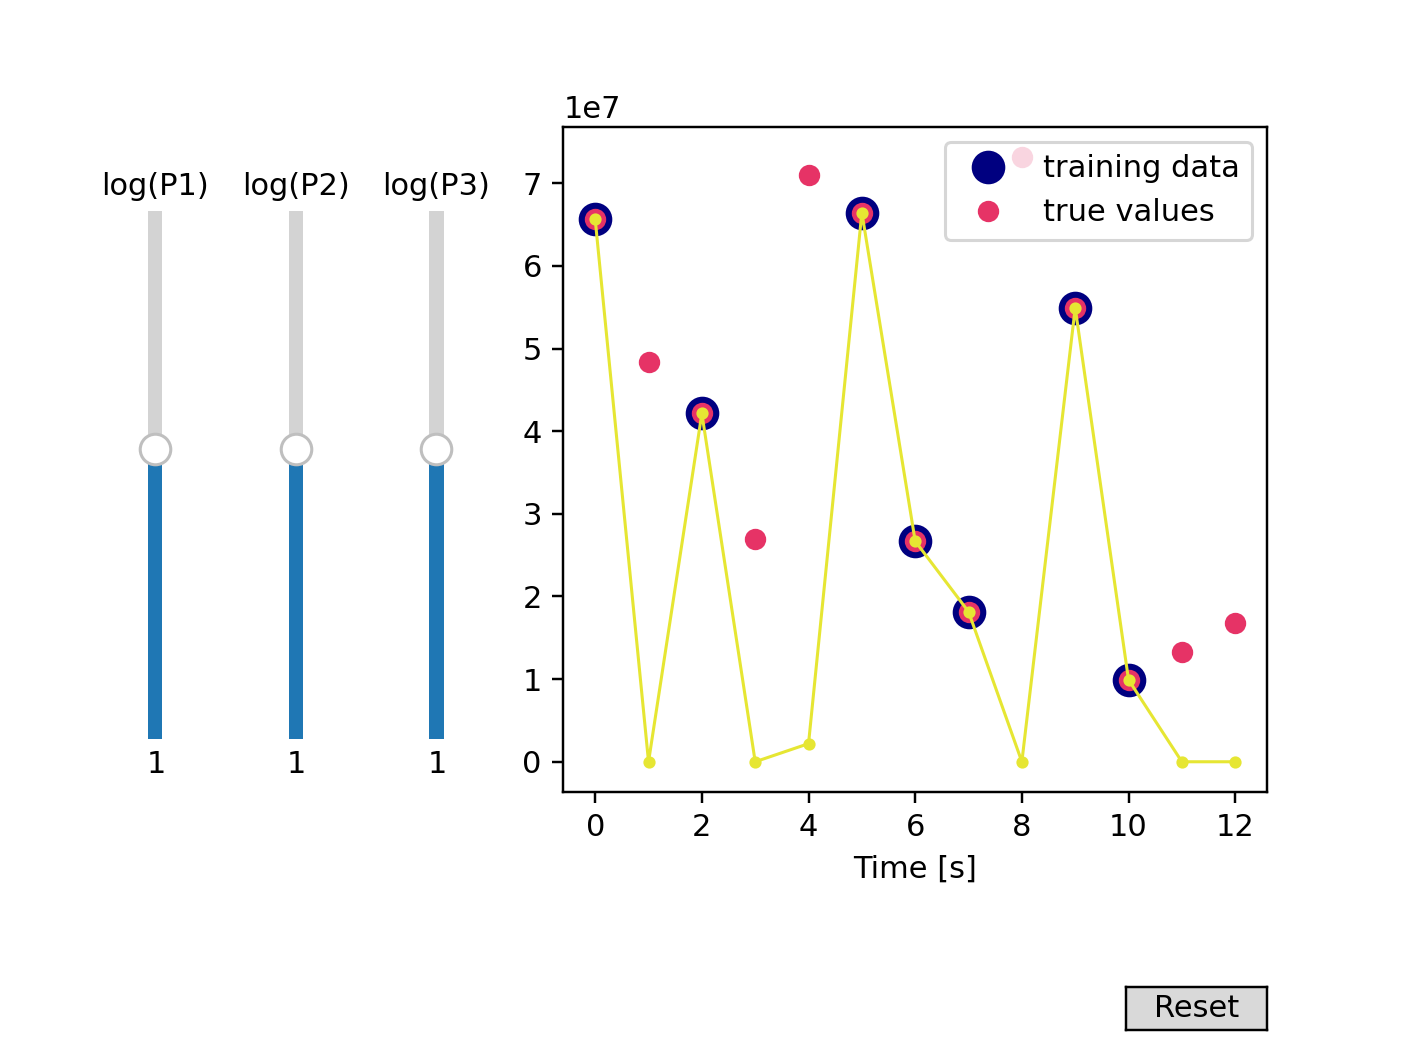

In [53]:
bt.analysis.parameter_tuner_3d(all_x_, all_y_, n) #, training_subset = n)

The ```btjenesten``` module additionally allow for some automated optimization of these parameters, but please pay careful attention to it as it is prone to numerical instabilities:

In [62]:
params_optimized = parameter_optimization(all_x_, all_y_, training_subset = n) 


print("Optimized parameters:", params_optimized)

Optimized parameters: [8.63701556e-04 1.59154381e-01 1.11983321e-08]


When you are satisfied with the regressor parameters, you can finally set up a regressor using the full data set. Insert your choice of parameters below:

In [63]:
regressor = bt.gpr.Regressor(all_x_, all_y_)

#params = bt.analysis.parameter_optimization(all_x_, all_y_, training_fraction = .99)
p1 = 10**-1
p2 = 10**-1
p3 = 10**-1
regressor.params = np.array([p1,p2,p3])

The ```btjenesten.gpr``` module should reproduce the training data flawlessly:

In [64]:
# Uses all the x data to predict the corresponding y-values with the regressor.
y_pred = regressor.predict(all_x_) # This will be compared to the measured values.


print("Predictions       | True values ")
print(np.vstack([y_pred, all_y_]).T)

Predictions       | True values 
[[65626517.         65626517.        ]
 [48406988.         48406988.        ]
 [42143802.         42143802.        ]
 [26975625.         26975625.        ]
 [70941284.         70941284.        ]
 [66452676.99999999 66452677.        ]
 [26688204.         26688204.        ]
 [18157839.         18157839.        ]
 [73184566.         73184566.        ]
 [54919876.         54919876.        ]
 [ 9915204.          9915204.        ]
 [13288195.         13288195.        ]
 [16780785.33333333 16780785.33333333]]


```{admonition} Discussion 3
- Make an enumerated list of the steps performed in this sections. What is the purpose of each step?
- How do changing the training data alter the predicted response and choice of parameters? (Try it out)
- How would you go about systematically improving the prediction?
```

In [ ]:
"""
Answer: 

"""

# Visualizing the response surface

An important feature of regressors is their ability to predict values outside the training data set. Generally speaking, we can distinguish between *interpolating* from *extrapolating* predictions. Common to all regressors is the fact that they are much better at making predictions close to the training data, in effect interpolating between the measured values. As we move further apart, we leave the domain of interpolation and instead enter the domain of extrapolation. 

The ```btjenesten.gpr``` module seeks predicted optimas in both these domains, and can be controlled to stay close to our training set or be more hungry for exploration. At any rate, a proposed optimum may be sought by the ```btjenesten.gpr.acquisition```-method as follows:

In [65]:
new_x = regressor.aquisition(method = "COBYLA", minimize_prediction=False, l = 0) # acquiring the x-coordinates for the regressor's maxima.

print("The dimensions for the next suggested measurement: ", new_x[0])
print("The new measurement's predicted output (the maxima of the regressor): ", regressor.predict(new_x)[0])

The dimensions for the next suggested measurement:  [60.00001451 -1.06826039 17.99194606]
The new measurement's predicted output (the maxima of the regressor):  191344616.82626963


```{warning} 
Depending on the training data picked out, the new proposed measurement might contain negative values. Is this possible for any of the dimensions in this analysis? Or does it violate any constraints for the experiment? Is there any situation (theoretically) where a dimension can be negative? 
```

In [66]:
"""
Answer:
"""

'\nAnswer:\n'

In order to fix the issue of negative values occuring for our dimension's  proposed maxima, the following line of code may be added:

In [67]:
# constrain proposed values to larger than 0
new_x_ = np.max(np.stack([new_x[0],np.zeros(3, dtype = float)]), axis = 0)

print("The realistic dimensions for the next suggested measurement: ", new_x_)



The realistic dimensions for the next suggested measurement:  [60.00001451  0.         17.99194606]


Finally, let's inspect our results visually by calling the ```btjenesten.analysis.one_dimensional_plots```-function:

<IPython.core.display.Javascript object>


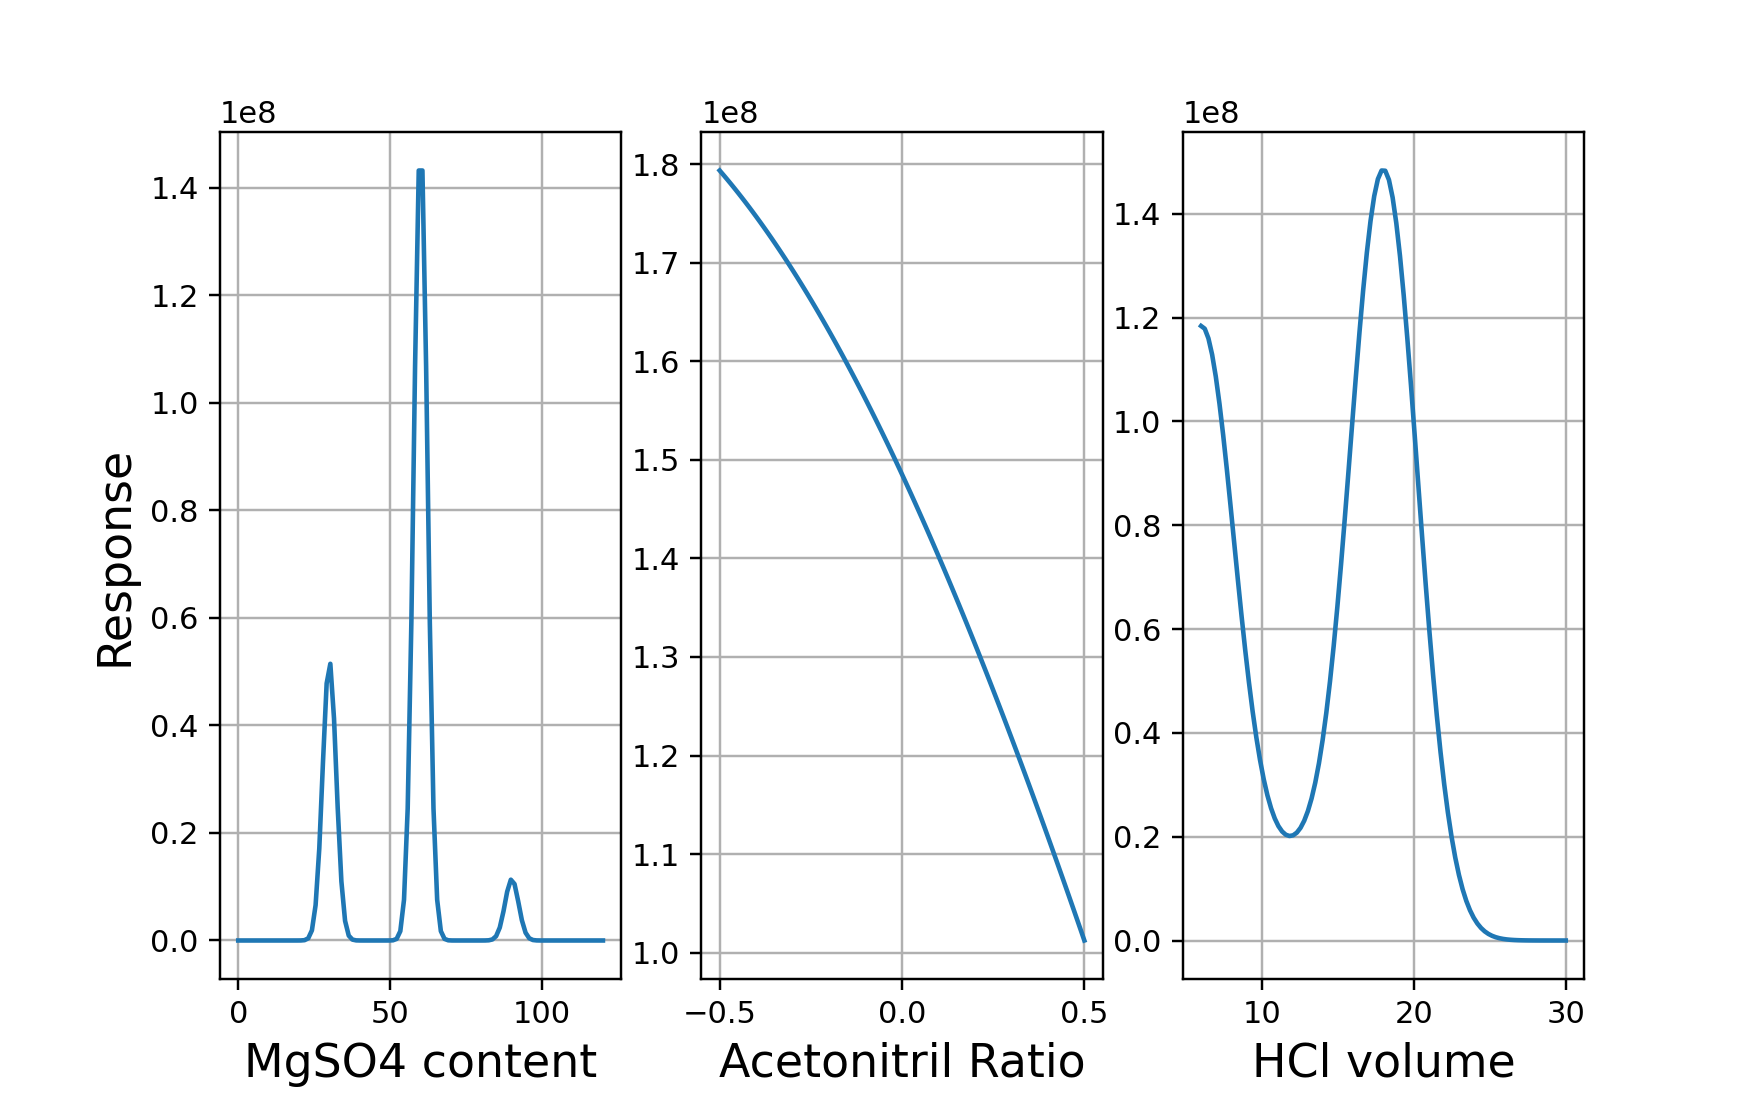

In [70]:
plots = bt.analysis.one_dimensional_plots(all_x_, new_x_, regressor, ["Response", "", ""],  ("MgSO4 content", "Acetonitril Ratio", "HCl volume", "Real Response", "Predicted Response")) # setting up the plots with our data.
plots # Calling the plotting function. 

```{admonition} Discussion 4
- What does the above plots show us?
- How do the figures change when the training data in part 3 changes? What does this show us? 
- How reliable are these figures when it comes to determining what the optimal dimensions are? 
- How do these two figures compare to each other? 
```

In [ ]:
"""
Answer
"""

# Visualizing interdependencies

The ```btjenesten.gpr``` prediction is always single valued, meaning that it takes in a $N$-dimensional vector and returns a scalar number. Such multivariate functions are difficult to visualize, since they are essentially densities in $N$-dimensional space. We can, however, allow only some few variables to vary, and leave the remaining fixed, and in this way display cross-sections of densities in lower dimensions.

Below, we extract two-dimensional cross-sections (surfaces) from the regressor-predictions, in order to get more information on the area around the measurements.

<IPython.core.display.Javascript object>


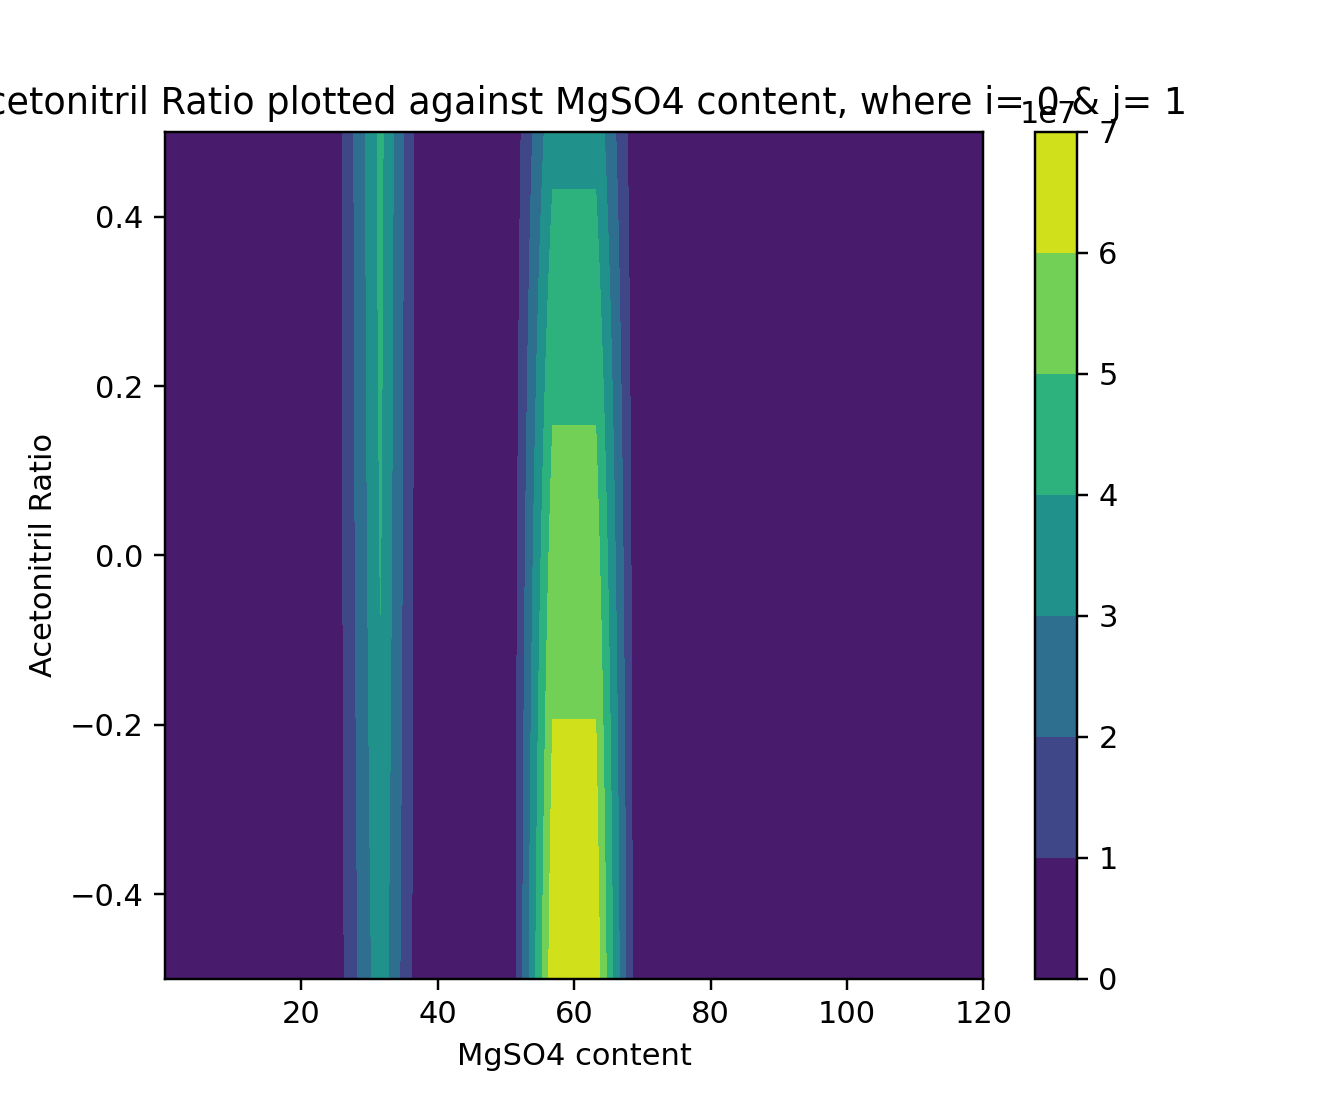

<IPython.core.display.Javascript object>


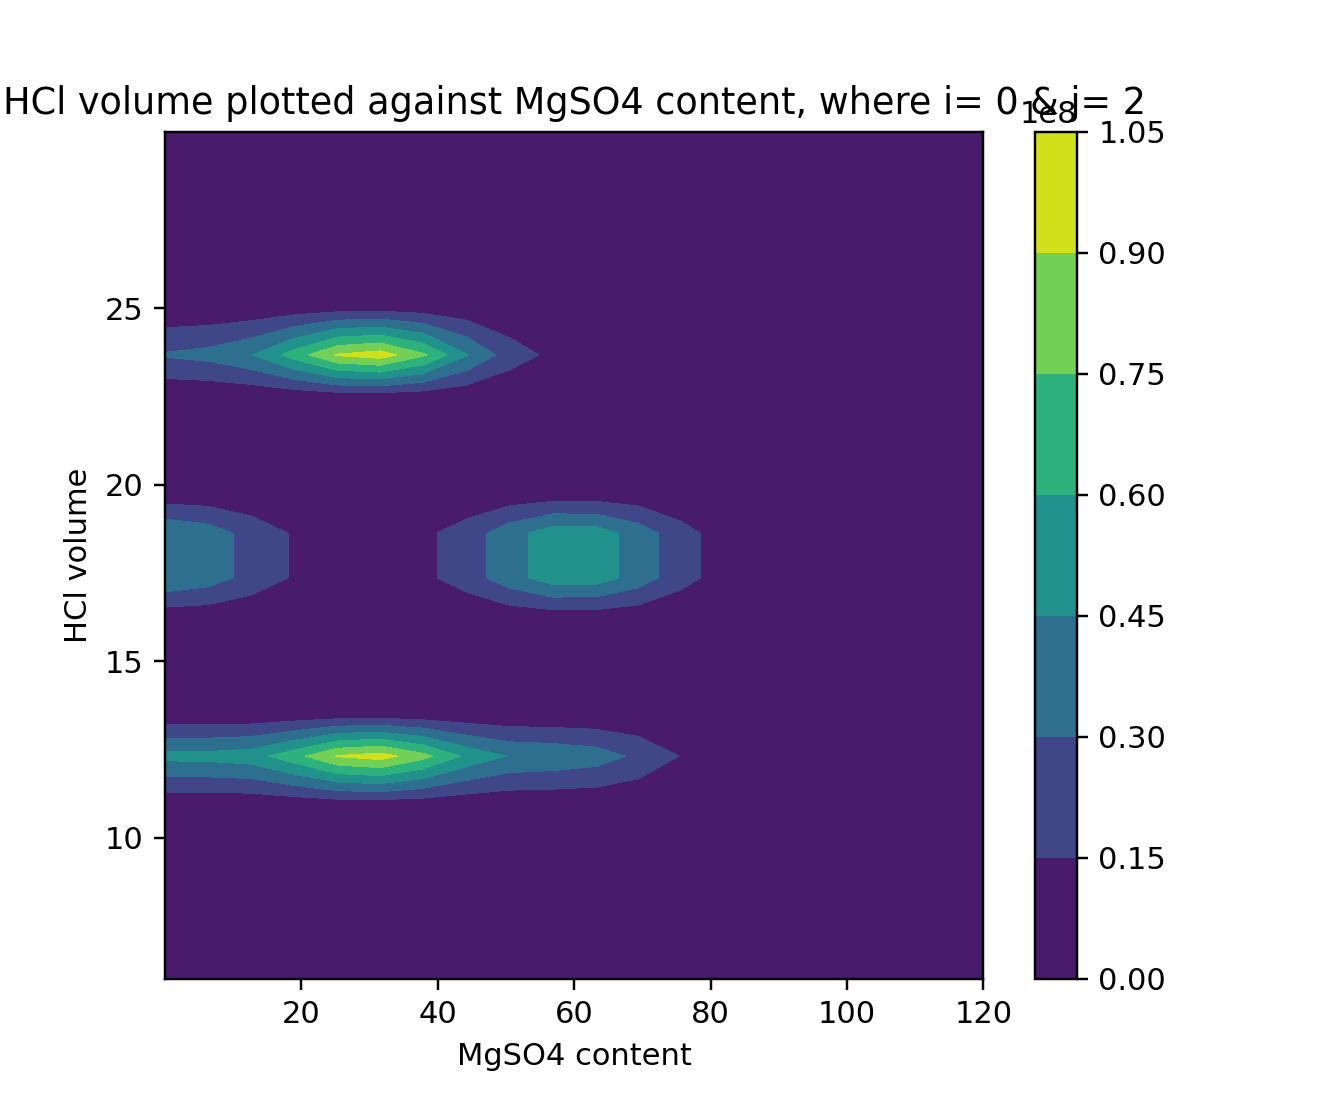

<IPython.core.display.Javascript object>


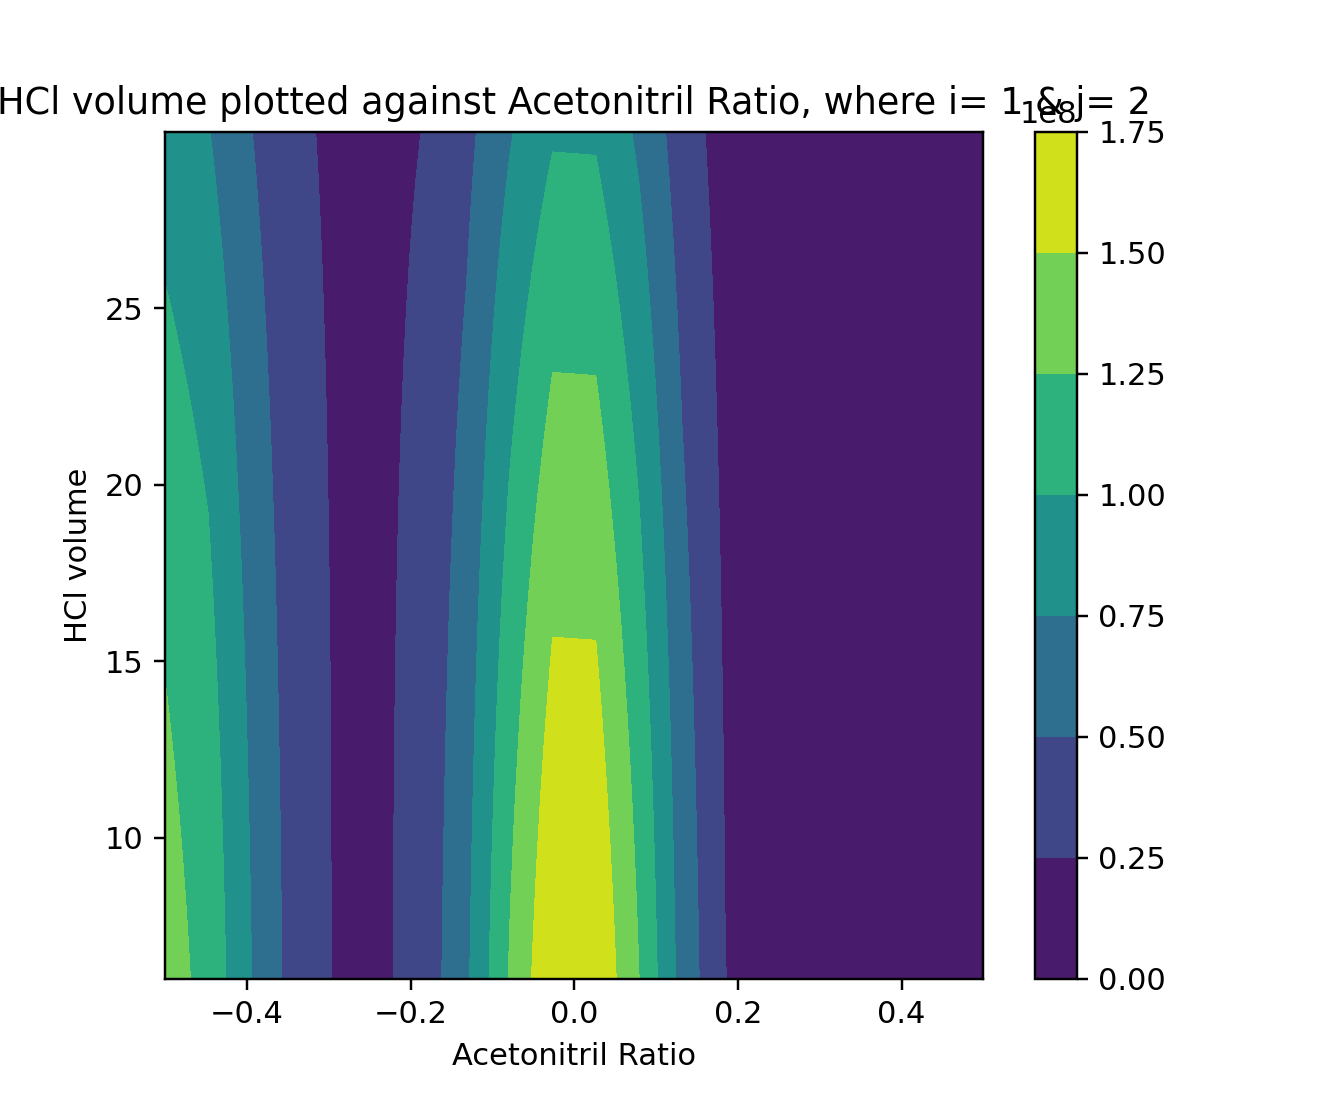

In [72]:
S = ("MgSO4 content", "Acetonitril Ratio", "HCl volume")

for i in range(3):
    for j in range(i+1, 3):

        x,y = bt.analysis.data_projection(regressor, axes = [i,j], center = new_x_)#np.array([new_measurements[-1]]))
        
        plt.figure(figsize =(6,5))
        plt.title(f"{S[j]} plotted against {S[i]}, where i= {i} & j= {j}")
        plt.xlabel(S[i])
        plt.ylabel(S[j])
        plt.contourf(x[0], x[1], y)
        plt.colorbar()
        plt.show()


```{admonition} Discussion 5
- How to we determine where to start the measurements?
- Why can't the computer tell us where to start out?
- What happens when a non optimal starting point is chosen? 
- What determines the minimal amount of starting measurements? Think: what would the regressor look like if one starting measurement was used vs two vs three? 
```

In [ ]:
"""
Answers: 

"""

# Final preparations for the lab

Okay, now that we have completed this module, propose where our initial measurements should be in the lab 4. 

```{admonition} Discussion 6
- Which levels should each dimension have in your opinion? 
- Can this information from last year's box behnken excercise be used as a starting point (training data) for 
    the new regressor? Why/why not? Hint: Remember why taking measurements over several days is often not 
    recommended. 
- What is the desired amount of measurements that should be necessary to find the maxima?
 - **Extra:** How would you set up this experiment? Think about time constraints, how errors can propagate (how to dix that), load on the user and how to store your analyte solutions.
```